# Multiomics Integration with scGALA-enhanced Seurat

This tutorial demonstrates how to integrate single-cell RNA-seq and ATAC-seq data using scGALA with Seurat. The scGALA framework enhances existing single-cell integration methods by replacing their core cell alignment modules while preserving their established workflows.

## Example Data
The preprocessed data used in this tutorial is available at [FigShare](https://figshare.com/articles/dataset/Label_Transfer_Example_Data/28728617).

## Overview

The scGALA enhancement strategy:
1. Capitalizes on robust graph-based cell alignments generated through the GAT architecture
2. Utilizes score-based optimization to improve cell matching
3. Seamlessly integrates these improved alignments into the Seurat pipeline
4. Maintains the fundamental structure of the Seurat method while upgrading alignment capabilities

In this tutorial, we'll integrate mouse cortex scRNA-seq and scATAC-seq data using the scGALA-enhanced Seurat workflow.

## Setting up the environment

First, let's load the necessary libraries. We'll need Seurat and Signac for multimodal analysis.

In [ ]:
suppressPackageStartupMessages({
    library(Seurat)
    library(Signac)
    library(yaml)
})

## Helper functions

To facilitate data loading, we define a function to read AnnData (`.h5ad`) files, which are commonly used to store single-cell data in Python-based analysis pipelines. This function allows us to import data processed by scanpy or other Python tools.

In [ ]:
read_h5ad <- function(filename) {
    reticulate::use_condaenv('scGALA', required = TRUE)
    builtins <- reticulate::import_builtins()
    anndata <- reticulate::import("anndata", convert = FALSE)

    Mapping <- reticulate::import("typing")$Mapping
    DataFrame <- reticulate::import("pandas")$DataFrame
    issparse <- reticulate::import("scipy.sparse")$issparse
    isinstance <- builtins$isinstance

    adata <- anndata$read_h5ad(filename)

    .convert <- function(obj) {
        if (!isinstance(obj, Mapping) || isinstance(obj, DataFrame)) {
            return(reticulate::py_to_r(obj))
        }
        ret <- list()
        for (item in builtins$list(obj$keys())) {
            ret[[item]] <- .convert(obj[[item]])
        }
        return(ret)
    }

    if (issparse(adata$X)) {
        X <- .convert(adata$X$tocsc())
    } else {
        X <- .convert(adata$X)
    }
    layers <- .convert(adata$layers)
    obs <- .convert(adata$obs)
    var <- .convert(adata$var)
    obsm <- .convert(adata$obsm)
    varm <- .convert(adata$varm)
    obsp <- .convert(adata$obsp)
    varp <- .convert(adata$varp)
    uns <- .convert(adata$uns)
    rownames(X) <- rownames(obs)
    colnames(X) <- rownames(var)

    return(list(
        X = X, layers = layers,
        obs = obs, var = var,
        obsm = obsm, varm = varm,
        obsp = obsp, varp = varp,
        uns = uns
    ))
}

## Data input configuration

Define paths to input data and output locations. We'll be using RNA-seq and ATAC-seq data from mouse cortex samples. The preprocessing script is provided in `preprocess_common_var_multiomics_integration.py` in the [scripts folder](https://github.com/mcgilldinglab/scGALA/tree/main/docs/tutorials/scripts). The preprocessed data is provided in [FigShare](https://figshare.com/articles/dataset/Label_Transfer_Example_Data/28728617).

In [ ]:
input_rna="./rna_preprocessed.h5ad" 
input_atac="./atac_preprocessed.h5ad" 
input_atac2rna="./atac2rna.h5ad" 
random_seed=2233 
output_rna="./experiment/seurat/ori/rna.csv" 
output_atac="./experiment/seurat/ori/atac.csv" 
run_info="./experiment/seurat/ori/run_info.yaml" 

## Data Loading and Preparation

In this section, we load the preprocessed RNA and ATAC data, along with the activity matrix that connects ATAC peaks to gene expression. The activity matrix is crucial for establishing relationships between the two modalities based on regulatory elements.

In [ ]:
set.seed(random_seed)
cat("[1/4] Reading data...\n")
# Load RNA data, ATAC data, and ATAC-to-RNA activity matrix (gene activity scores derived from chromatin accessibility)
rna <- read_h5ad(input_rna)
atac <- read_h5ad(input_atac)
atac2rna <- read_h5ad(input_atac2rna)
# Verify data consistency
stopifnot(all(rownames(atac2rna$var) == rownames(rna$var)))
stopifnot(all(rownames(atac2rna$obs) == rownames(atac$obs)))
# Add modality suffix to avoid cell name collisions
rownames(rna$obs) <- paste(rownames(rna$obs), "RNA", sep = ".")  # Avoid collision
rownames(rna$X) <- rownames(rna$obs)
# Create Seurat object for RNA data
rna.so <- CreateSeuratObject(counts = Matrix::t(rna$X), assay = "RNA", meta.data = rna$obs)
# Add modality suffix for ATAC cells
rownames(atac$obs) <- paste(rownames(atac$obs), "ATAC", sep = ".")  # Avoid collision
rownames(atac$X) <- rownames(atac$obs)
# Create Seurat object for ATAC data
atac.so <- CreateSeuratObject(counts = Matrix::t(atac$X), assay = "ATAC", meta.data = atac$obs)
# Add the gene activity scores as an additional assay
rownames(atac2rna$obs) <- paste(rownames(atac2rna$obs), "ATAC", sep = ".")  # Avoid collision
rownames(atac2rna$X) <- rownames(atac2rna$obs)
atac.so[["ACTIVITY"]] <- CreateAssayObject(counts = Matrix::t(atac2rna$X))
# Extract highly variable genes for integration
hvg <- rownames(rna$var)[rna$var$highly_variable]
n_cells <- nrow(rna$obs) + nrow(atac$obs)
# Clean up to reduce memory usage
rm(rna, atac, atac2rna)
gc()  # Reduce memory usage


[1/4] Reading data...


,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,6586595,351.8,11885454,634.8,7929603,423.5
Vcells,550378635,4199.1,1697179501,12948.5,2033479332,15514.3


## Data Preprocessing

Before integration, both RNA and ATAC datasets require proper normalization and dimensionality reduction. For RNA-seq, we set variable features, scale data, and run PCA. For ATAC-seq, we perform TF-IDF normalization and singular value decomposition, which are standard practices for chromatin accessibility data.

In [ ]:
cat("[2/4] Data preprocessing...\n")
start_time <- proc.time()
# Process RNA data: set variable features, scale, and run PCA
# Note: Data is already normalized in preprocessed input
# rna.so <- NormalizeData(rna.so)
VariableFeatures(rna.so) <- hvg  # Use pre-computed highly variable genes
rna.so <- ScaleData(rna.so)
rna.so <- RunPCA(rna.so, seed.use = random_seed, verbose = FALSE)

# Process ATAC gene activity data: select the same variable features as RNA for integration
DefaultAssay(atac.so) <- "ACTIVITY"
VariableFeatures(atac.so) <- hvg  # Use same features as RNA for better integration
# atac.so <- NormalizeData(atac.so)
atac.so <- ScaleData(atac.so)

# Process ATAC peak data: perform TF-IDF normalization and dimension reduction
DefaultAssay(atac.so) <- "ATAC"
atac.so <- RunTFIDF(atac.so)  # Term frequency-inverse document frequency normalization
atac.so <- FindTopFeatures(atac.so, min.cutoff = "q0")  # Select informative peaks
atac.so <- RunSVD(atac.so)  # Singular value decomposition, similar to PCA


[2/4] Data preprocessing...


Centering and scaling data matrix

Centering and scaling data matrix

Performing TF-IDF normalization

Running SVD

Scaling cell embeddings



## Identifying Anchors Between Modalities

This is where the standard Seurat workflow identifies cell pairs ("anchors") that connect the two modalities. The anchors are identified by first projecting both datasets into a common space using canonical correlation analysis (CCA), then finding mutual nearest neighbors between the two datasets in this shared space. These anchors will be the basis for transferring information between modalities.

In [ ]:
cat("[3/4] Running CCA anchor...\n")
# Find transfer anchors between RNA and ATAC modalities using gene activity scores
# These anchors represent corresponding cells between modalities
transfer.anchors <- FindTransferAnchors(
    reference = rna.so, query = atac.so,
    features = VariableFeatures(rna.so),  # Use variable genes for calculating correlations
    reference.assay = "RNA", query.assay = "ACTIVITY",  # Connect RNA to gene activity scores
    reduction = "cca"  # Use canonical correlation analysis
)

# Save the transfer anchors to a CSV file and enhance with scGALA as in Label Transfer tutorial
write.csv(transfer.anchors@anchors, file = "ori_anchors.csv", row.names = FALSE)

[3/4] Running CCA anchor...


Warning message in RunCCA.Seurat(object1 = reference, object2 = query, features = features, :
“Running CCA on different assays”
Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 24838 anchors

Filtering anchors

	Retained 4993 anchors



## Run scGALA Enhancement

This is where scGALA's enhancement takes place. Instead of using the anchors identified by the standard Seurat method, we replace them with anchors identified by scGALA. 

scGALA leverages Graph Attention Networks (GAT) to create a more robust and accurate matching between cells across modalities. The key advantages are:

1. Better handling of batch effects and biological variations
2. More accurate identification of corresponding cell populations
3. Enhanced performance for downstream tasks like label transfer and imputation
4. Preservation of the original biological structure in each modality

The scGALA module runs separately, which we'll load next.

In [ ]:
# Load scGALA-enhanced anchors to replace standard Seurat anchors
anchors_new <- read.csv("./mod_anchors.csv")
# Adjust indices (Python uses 0-based indexing, R uses 1-based indexing)
anchors_new$cell1 <- anchors_new$cell1 +1
anchors_new$cell2 <- anchors_new$cell2 +1
# Replace the standard anchors with scGALA-enhanced anchors
transfer.anchors@anchors <- anchors_new

## Multimodal Integration with Enhanced Anchors

Now we'll use the scGALA-enhanced anchors to perform integration. This involves:

1. Transferring gene expression data from RNA to ATAC modality (imputation)
2. Merging the datasets into a joint embedding
3. Running dimensionality reduction on the integrated data

With scGALA's enhanced anchors, these steps should produce more biologically meaningful results while maintaining the standard Seurat workflow.

In [ ]:
# Extract RNA expression data for transfer to ATAC cells
refdata <- GetAssayData(
    rna.so, assay = "RNA", slot = "data"
)[VariableFeatures(rna.so), ]
# Transfer RNA expression patterns to ATAC cells using scGALA-enhanced anchors
imputation <- TransferData(
    anchorset = transfer.anchors, refdata = refdata,
    weight.reduction = atac.so[["lsi"]], dims = 1:30
)
# Add imputed RNA expression as a new assay in the ATAC object
atac.so[["RNA"]] <- imputation
# Merge RNA and ATAC objects into a single multimodal object
coembed.so <- merge(x = rna.so, y = atac.so)
# Scale the merged data
coembed.so <- ScaleData(
    coembed.so, features = VariableFeatures(rna.so), do.scale = FALSE
)
# Run PCA on the integrated data using variable genes
coembed.so <- RunPCA(
    coembed.so, features = VariableFeatures(rna.so),
    seed.use = random_seed, verbose = FALSE
)
elapsed_time <- proc.time() - start_time

Finding integration vectors

Finding integration vector weights

Transfering 2000 features onto reference data

Centering data matrix



## Setting Output Paths

Define paths to save our integration results, including latent representations and imputed data.

In [ ]:
output_rna="./experiment/seurat/mod/rna.csv" 
output_atac="./experiment/seurat/mod/atac.csv" 
output_imputation="./experiment/seurat/mod/imputation.csv"

## Saving Integration Results

Finally, we'll save the results of the integration, including:
1. The low-dimensional representations of RNA cells
2. The low-dimensional representations of ATAC cells
3. The imputed gene expression for ATAC cells

These outputs can be used for downstream analysis, visualization, and biological interpretation.

In [ ]:
cat("[4/4] Saving results...\n")
# Extract PCA embeddings from the combined object
combined_latent <- Embeddings(coembed.so)
# Separate RNA cell embeddings and remove the modality suffix
rna_latent <- combined_latent[colnames(rna.so), ]
rownames(rna_latent) <- gsub("\\.RNA$", "", rownames(rna_latent))
# Separate ATAC cell embeddings and remove the modality suffix
atac_latent <- combined_latent[colnames(atac.so), ]
rownames(atac_latent) <- gsub("\\.ATAC$", "", rownames(atac_latent))
# Save RNA cell embeddings
write.table(
    rna_latent, output_rna,
    sep = ",", row.names = TRUE, col.names = FALSE, quote = FALSE
)
# Save ATAC cell embeddings
write.table(
    atac_latent, output_atac,
    sep = ",", row.names = TRUE, col.names = FALSE, quote = FALSE
)
# write_yaml(
#     list(
#         args = args,
#         time = elapsed_time["elapsed"],
#         n_cells = n_cells
#     ), run_info
# )

[4/4] Saving results...


In [ ]:
# Save imputed gene expression data for ATAC cells
write.csv(imputation@data, file = output_imputation)

## Evaluation (Change into Python kernel)

In [ ]:
import scanpy as sc
import pandas as pd
import scib

In [ ]:
## Read the original data to get the gene names
data_dir = "./"
rna = sc.read(data_dir+'rna_preprocessed.h5ad')
atac = sc.read(data_dir+'atac_preprocessed.h5ad')
atac2rna = sc.read(data_dir+'atac2rna.h5ad')
seurat_dir = './experiment/seurat/mod/'

## Read the imputed data and construct the AnnData object
rna_imputation = pd.read_csv(seurat_dir+'imputation.csv', index_col=0).T
rna = rna[:,rna.var.highly_variable]
atac2rna = atac2rna[:,rna.var.index]
rna_imputed = sc.AnnData(X=rna_imputation.values, obs=atac.obs, var=rna.var)
combined_imputed = sc.concat([rna,rna_imputed],keys=['rna','atac'], index_unique='-')

/mnt/md0/guo/miniforge3/envs/ggmnn_scanorama/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/mnt/md0/guo/miniforge3/envs/ggmnn_scanorama/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/mnt/md0/guo/miniforge3/envs/ggmnn_scanorama/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/mnt/md0/guo/miniforge3/envs/ggmnn_scanorama/lib/python3.9/site-packages/scanpy/plotting

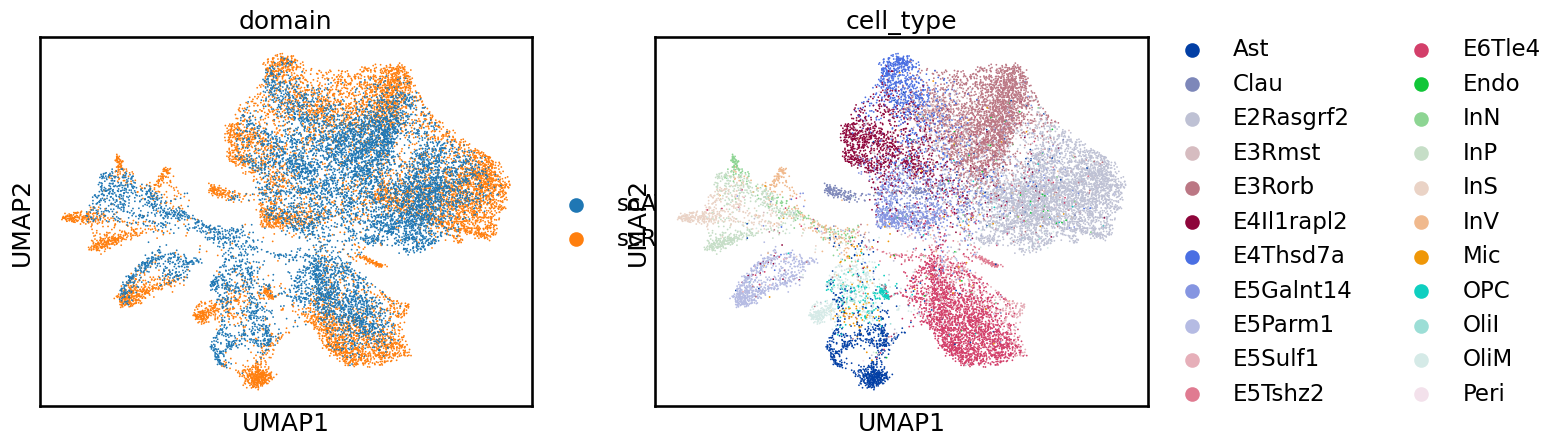

In [ ]:
## Use the imputed data for PCA and UMAP
sc.pp.pca(combined_imputed)
sc.pp.neighbors(combined_imputed)
sc.tl.umap(combined_imputed)
sc.pl.umap(combined_imputed, color=['domain','cell_type'])

In [ ]:
# Use the imputed data for optimal clustering based on scIB
scib.me.cluster_optimal_resolution(combined_imputed, cluster_key="cluster", label_key='cell_type')
adata_ori = sc.concat([rna,atac2rna],keys=['rna','atac'], index_unique='-')

resolution: 0.1, nmi: 0.5127057800424288
resolution: 0.2, nmi: 0.6197436232302748
resolution: 0.3, nmi: 0.6203606863478037
resolution: 0.4, nmi: 0.6288503998437203
resolution: 0.5, nmi: 0.6280297156449285
resolution: 0.6, nmi: 0.6377061881437341
resolution: 0.7, nmi: 0.6177874115466445
resolution: 0.8, nmi: 0.5980103056127214
resolution: 0.9, nmi: 0.6044316113014258
resolution: 1.0, nmi: 0.5749199810085582
resolution: 1.1, nmi: 0.5762098911678715
resolution: 1.2, nmi: 0.5618217204343654
resolution: 1.3, nmi: 0.5656207803350063
resolution: 1.4, nmi: 0.5519092230690323
resolution: 1.5, nmi: 0.5597321989675951
resolution: 1.6, nmi: 0.5577258236914697
resolution: 1.7, nmi: 0.5519887940204404
resolution: 1.8, nmi: 0.5436846629050364
resolution: 1.9, nmi: 0.553547942775471
resolution: 2.0, nmi: 0.5452242824119777
optimised clustering against cell_type
optimal cluster resolution: 0.6
optimal score: 0.6377061881437341


In [ ]:
# Calculate metrics using scIB
metrics = scib.metrics.metrics(adata=adata_ori,
                     adata_int=combined_imputed,
                     batch_key='domain',
                     label_key='cell_type',
        isolated_labels_asw_=True,
        silhouette_=True,
        hvg_score_=False,
        graph_conn_=True,
        pcr_=False,
        isolated_labels_f1_=False,
        trajectory_=False,
        nmi_=True,
        ari_=True,
        cell_cycle_=False,
        kBET_=True,
        ilisi_=False,
        clisi_=False,
)
# metrics.to_csv('Results/metrics/'+'hum_moe'+'_'+'mnnpy_replaced'+'.csv')
metrics

/mnt/md0/guo/miniforge3/envs/ggmnn_scanorama/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Isolated labels ASW...


/mnt/md0/guo/miniforge3/envs/ggmnn_scanorama/lib/python3.9/site-packages/scib/metrics/isolated_labels.py:272: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  batch_per_lab = tmp.groupby(label_key).agg({batch_key: "count"})


Graph connectivity...
kBET...


/mnt/md0/guo/miniforge3/envs/ggmnn_scanorama/lib/python3.9/site-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/mnt/md0/guo/miniforge3/envs/ggmnn_scanorama/lib/python3.9/site-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/mnt/md0/guo/miniforge3/envs/ggmnn_scanorama/lib/python3.9/site-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/mnt/md0/guo/miniforge3/envs/ggmnn_scanorama/lib/python3.9/site-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will

Adding diffusion to step 4
Adding diffusion to step 5
Adding diffusion to step 6


/mnt/md0/guo/miniforge3/envs/ggmnn_scanorama/lib/python3.9/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()
/mnt/md0/guo/miniforge3/envs/ggmnn_scanorama/lib/python3.9/site-packages/scib/metrics/kbet.py:158: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


Adding diffusion to step 4
Adding diffusion to step 5


/mnt/md0/guo/miniforge3/envs/ggmnn_scanorama/lib/python3.9/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()
/mnt/md0/guo/miniforge3/envs/ggmnn_scanorama/lib/python3.9/site-packages/scib/metrics/kbet.py:158: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


Adding diffusion to step 4


/mnt/md0/guo/miniforge3/envs/ggmnn_scanorama/lib/python3.9/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()
/mnt/md0/guo/miniforge3/envs/ggmnn_scanorama/lib/python3.9/site-packages/scib/metrics/kbet.py:158: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


Adding diffusion to step 4


/mnt/md0/guo/miniforge3/envs/ggmnn_scanorama/lib/python3.9/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()
/mnt/md0/guo/miniforge3/envs/ggmnn_scanorama/lib/python3.9/site-packages/scib/metrics/kbet.py:158: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


Adding diffusion to step 4
Adding diffusion to step 5


/mnt/md0/guo/miniforge3/envs/ggmnn_scanorama/lib/python3.9/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()
/mnt/md0/guo/miniforge3/envs/ggmnn_scanorama/lib/python3.9/site-packages/scib/metrics/kbet.py:158: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


Adding diffusion to step 4
Adding diffusion to step 5


/mnt/md0/guo/miniforge3/envs/ggmnn_scanorama/lib/python3.9/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()
/mnt/md0/guo/miniforge3/envs/ggmnn_scanorama/lib/python3.9/site-packages/scib/metrics/kbet.py:158: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/mnt/md0/guo/miniforge3/envs/ggmnn_scanorama/lib/python3.9/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


Adding diffusion to step 4
Adding diffusion to step 5


/mnt/md0/guo/miniforge3/envs/ggmnn_scanorama/lib/python3.9/site-packages/scib/metrics/kbet.py:158: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/mnt/md0/guo/miniforge3/envs/ggmnn_scanorama/lib/python3.9/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


Adding diffusion to step 4


/mnt/md0/guo/miniforge3/envs/ggmnn_scanorama/lib/python3.9/site-packages/scib/metrics/kbet.py:158: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


Adding diffusion to step 4


/mnt/md0/guo/miniforge3/envs/ggmnn_scanorama/lib/python3.9/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()
/mnt/md0/guo/miniforge3/envs/ggmnn_scanorama/lib/python3.9/site-packages/scib/metrics/kbet.py:158: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/mnt/md0/guo/miniforge3/envs/ggmnn_scanorama/lib/python3.9/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


Adding diffusion to step 4


/mnt/md0/guo/miniforge3/envs/ggmnn_scanorama/lib/python3.9/site-packages/scib/metrics/kbet.py:158: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/mnt/md0/guo/miniforge3/envs/ggmnn_scanorama/lib/python3.9/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


Adding diffusion to step 4
Adding diffusion to step 5


/mnt/md0/guo/miniforge3/envs/ggmnn_scanorama/lib/python3.9/site-packages/scib/metrics/kbet.py:158: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/mnt/md0/guo/miniforge3/envs/ggmnn_scanorama/lib/python3.9/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


Adding diffusion to step 4


/mnt/md0/guo/miniforge3/envs/ggmnn_scanorama/lib/python3.9/site-packages/scib/metrics/kbet.py:158: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


Adding diffusion to step 4
Adding diffusion to step 5


/mnt/md0/guo/miniforge3/envs/ggmnn_scanorama/lib/python3.9/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()
/mnt/md0/guo/miniforge3/envs/ggmnn_scanorama/lib/python3.9/site-packages/scib/metrics/kbet.py:158: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/mnt/md0/guo/miniforge3/envs/ggmnn_scanorama/lib/python3.9/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


Adding diffusion to step 4


/mnt/md0/guo/miniforge3/envs/ggmnn_scanorama/lib/python3.9/site-packages/scib/metrics/kbet.py:158: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/mnt/md0/guo/miniforge3/envs/ggmnn_scanorama/lib/python3.9/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


Adding diffusion to step 4


/mnt/md0/guo/miniforge3/envs/ggmnn_scanorama/lib/python3.9/site-packages/scib/metrics/kbet.py:158: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/mnt/md0/guo/miniforge3/envs/ggmnn_scanorama/lib/python3.9/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


Adding diffusion to step 4
Adding diffusion to step 5


/mnt/md0/guo/miniforge3/envs/ggmnn_scanorama/lib/python3.9/site-packages/scib/metrics/kbet.py:158: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/mnt/md0/guo/miniforge3/envs/ggmnn_scanorama/lib/python3.9/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


Adding diffusion to step 4


/mnt/md0/guo/miniforge3/envs/ggmnn_scanorama/lib/python3.9/site-packages/scib/metrics/kbet.py:158: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/mnt/md0/guo/miniforge3/envs/ggmnn_scanorama/lib/python3.9/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


Adding diffusion to step 4


/mnt/md0/guo/miniforge3/envs/ggmnn_scanorama/lib/python3.9/site-packages/scib/metrics/kbet.py:158: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/mnt/md0/guo/miniforge3/envs/ggmnn_scanorama/lib/python3.9/site-packages/scib/metrics/kbet.py:158: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/mnt/md0/guo/miniforge3/envs/ggmnn_scanorama/lib/python3.9/site-packages/scib/metrics/kbet.py:158: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/mnt/md0/guo/miniforge3/envs/ggmnn_scanorama/lib/python3.9/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be rem

Adding diffusion to step 4


,0
NMI_cluster/label,0.626183
ARI_cluster/label,0.632331
ASW_label,0.514382
ASW_label/batch,0.586607
PCR_batch,NaN
cell_cycle_conservation,NaN
isolated_label_F1,NaN
isolated_label_silhouette,0.466923
graph_conn,0.829353
kBET,0.131187


## Conclusion

In this tutorial, we've demonstrated how scGALA enhances the Seurat integration workflow for single-cell multiomics data. By replacing the standard anchor identification with scGALA's GGMNN approach, we achieve more accurate cell alignments between RNA and ATAC modalities while preserving the rest of the established Seurat workflow.

This approach can be applied to other single-cell integration methods as well, offering a flexible framework to enhance existing computational tools with more robust cell alignment capabilities.